<a href="https://colab.research.google.com/github/fdmy2713-dotcom/MSc-in-Data-Science/blob/main/Farah_ADS1_Assessment_2_Clustering_and_Fitting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LinearRegression

In [2]:
# ---------- FILE NAMES (Colab) ----------
MONTHLY_FILE = "monthly_ave_daily_pt_ridership.csv"
YEARLY_FILE = "PublicTransportUtilisationAveragePublicTransportRidership.csv"
PREMIUM_FILE = "PremiumBusServicesCSV20241125.csv"

In [7]:
# ============================================================
# 1. DATA LOADING FUNCTIONS
# ============================================================

def load_monthly_ridership():
    """
    Load monthly average daily public transport ridership.
    Expected columns: month, mode, ridership
    """
    df = pd.read_csv(MONTHLY_FILE)
    df['month'] = pd.to_datetime(df['month'], errors='coerce')
    df['ridership'] = pd.to_numeric(df['ridership'], errors='coerce')
    df = df.dropna(subset=['month', 'mode', 'ridership'])
    return df


def load_yearly_ridership():
    """
    Load yearly average daily public transport ridership.
    Expected columns: year, mode, ridership
    """
    df = pd.read_csv(YEARLY_FILE)
    df['year'] = pd.to_numeric(df['year'], errors='coerce')
    df['ridership'] = pd.to_numeric(df['ridership'], errors='coerce')
    df = df.dropna(subset=['year', 'mode', 'ridership'])
    return df


def load_premium_bus():
    """
    Load premium bus services data for clustering.
    Expected columns:
    BUS_SERVICE_NAME_TXT, OPR_DESC_TXT, ORIG_DEST_TXT, BUS_DIRCTN_TXT,
    BUS_ROUTE_SEQ_NUM, BUS_STOP_CD, BUS_STOP_DESC_TXT, RD_NAM_TXT,
    LONGTD_TXT, LATTD_TXT, OP_HR_TXT, FARE_TXT
    """
    df = pd.read_csv(PREMIUM_FILE, encoding='latin1')
    df['LONGTD_TXT'] = pd.to_numeric(df['LONGTD_TXT'], errors='coerce')
    df['LATTD_TXT'] = pd.to_numeric(df['LATTD_TXT'], errors='coerce')
    df = df.dropna(subset=['LONGTD_TXT', 'LATTD_TXT'])
    return df

In [4]:
# ============================================================
# 2. PLOTTING FUNCTIONS (ONE GRAPH PER FUNCTION)
# ============================================================

def plot_monthly_ridership_bar(df_monthly):
    """Bar chart of total monthly ridership aggregated over modes."""
    monthly_total = df_monthly.groupby('month')['ridership'].sum().reset_index()

    plt.figure(figsize=(10, 5))
    plt.bar(monthly_total['month'].dt.strftime('%Y-%m'), monthly_total['ridership'])
    plt.xticks(rotation=45, ha='right')
    plt.title("Total Average Daily Ridership by Month (All Modes)")
    plt.xlabel("Month")
    plt.ylabel("Average Daily Ridership")
    plt.tight_layout()
    plt.show()


def plot_mode_share_pie(df_yearly, year_filter=None):
    """Pie chart of mode share for a selected year."""
    if year_filter is None:
        year_filter = df_yearly['year'].max()

    df_year = df_yearly[df_yearly['year'] == year_filter]
    df_year = df_year.groupby('mode')['ridership'].sum().reset_index()

    plt.figure(figsize=(6, 6))
    plt.pie(df_year['ridership'], labels=df_year['mode'], autopct='%1.1f%%', startangle=90)
    plt.title(f"Mode Share of Average Daily Ridership in {int(year_filter)}")
    plt.tight_layout()
    plt.show()


def plot_yearly_ridership_line(df_yearly, mode_filter=None):
    """Line graph of yearly ridership."""
    if mode_filter is not None:
        df_plot = df_yearly[df_yearly['mode'] == mode_filter]
    else:
        df_plot = df_yearly.copy()

    plt.figure(figsize=(10, 5))

    if mode_filter is not None:
        df_plot = df_plot.sort_values('year')
        plt.plot(df_plot['year'], df_plot['ridership'], marker='o')
        plt.title(f"Yearly Average Daily Ridership – {mode_filter}")
    else:
        for mode, grp in df_plot.groupby('mode'):
            grp = grp.sort_values('year')
            plt.plot(grp['year'], grp['ridership'], marker='o', label=mode)
        plt.title("Yearly Average Daily Ridership by Mode")

    plt.xlabel("Year")
    plt.ylabel("Average Daily Ridership")
    if mode_filter is None:
        plt.legend()
    plt.tight_layout()
    plt.show()


def plot_yearly_ridership_scatter(df_yearly, mode_filter=None):
    """Scatter plot of year vs ridership."""
    if mode_filter is not None:
        df_plot = df_yearly[df_yearly['mode'] == mode_filter]
        title = f"Year vs Average Daily Ridership (Scatter) – {mode_filter}"
    else:
        df_plot = df_yearly.copy()
        title = "Year vs Average Daily Ridership (Scatter) – All Modes"

    plt.figure(figsize=(8, 5))
    plt.scatter(df_plot['year'], df_plot['ridership'])
    plt.xlabel("Year")
    plt.ylabel("Average Daily Ridership")
    plt.title(title)
    plt.tight_layout()
    plt.show()


def plot_ridership_heatmap(df_yearly):
    """Heatmap of ridership by year (rows) and mode (columns)."""
    pivot = df_yearly.pivot_table(index='year', columns='mode', values='ridership', aggfunc='sum')

    plt.figure(figsize=(8, 6))
    sns.heatmap(pivot, annot=True, fmt=".0f")
    plt.title("Heatmap of Average Daily Ridership by Year and Mode")
    plt.ylabel("Year")
    plt.xlabel("Mode")
    plt.tight_layout()
    plt.show()


def plot_monthly_boxplot(df_monthly):
    """Boxplot of monthly ridership by mode."""
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=df_monthly, x='mode', y='ridership')
    plt.xlabel("Mode")
    plt.ylabel("Average Daily Ridership")
    plt.title("Distribution of Monthly Average Daily Ridership by Mode")
    plt.tight_layout()
    plt.show()


def plot_elbow_curve(X, max_k=10):
    """Elbow plot for KMeans clustering inertia over different K values."""
    inertias = []
    ks = range(2, max_k + 1)

    for k in ks:
        model = KMeans(n_clusters=k, random_state=42, n_init=10)
        model.fit(X)
        inertias.append(model.inertia_)

    plt.figure(figsize=(8, 5))
    plt.plot(list(ks), inertias, marker='o')
    plt.xticks(list(ks))
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Inertia (Within-Cluster Sum of Squares)")
    plt.title("Elbow Plot for K-Means Clustering")
    plt.tight_layout()
    plt.show()


def plot_silhouette_scores(X, max_k=10):
    """Plot average silhouette score for different K values."""
    scores = []
    ks = range(2, max_k + 1)

    for k in ks:
        model = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = model.fit_predict(X)
        score = silhouette_score(X, labels)
        scores.append(score)

    plt.figure(figsize=(8, 5))
    plt.plot(list(ks), scores, marker='o')
    plt.xticks(list(ks))
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Average Silhouette Score")
    plt.title("Silhouette Scores for K-Means Clustering")
    plt.tight_layout()
    plt.show()


def plot_clustered_bus_stops(df_bus, labels):
    """Scatter plot of bus stop locations coloured by KMeans cluster label."""
    plt.figure(figsize=(8, 6))
    plt.scatter(df_bus['LONGTD_TXT'], df_bus['LATTD_TXT'], c=labels)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Premium Bus Stop Clusters (K-Means)")
    plt.tight_layout()
    plt.show()

In [5]:
# ============================================================
# 3. CLUSTERING & FITTING FUNCTIONS
# ============================================================

def prepare_bus_features_for_clustering(df_bus):
    """Prepare lat/long feature matrix and scaler for clustering."""
    X = df_bus[['LONGTD_TXT', 'LATTD_TXT']].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled, scaler


def run_kmeans_clustering(X_scaled, n_clusters=4):
    """Run KMeans clustering on scaled feature matrix X_scaled."""
    model = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = model.fit_predict(X_scaled)
    return model, labels


def perform_linear_regression(df_yearly, mode_filter=None):
    """Perform linear regression (line fitting) of ridership vs year."""
    if mode_filter is not None:
        df_fit = df_yearly[df_yearly['mode'] == mode_filter].copy()
    else:
        df_fit = df_yearly.copy()

    df_fit = df_fit.groupby('year')['ridership'].sum().reset_index()
    df_fit = df_fit.sort_values('year')

    X = df_fit[['year']].values
    y = df_fit['ridership'].values

    model = LinearRegression()
    model.fit(X, y)

    return model, X, y


def plot_linear_regression_fit(model, X, y, mode_filter=None):
    """Plot the data points and the regression line for ridership vs year."""
    y_pred = model.predict(X)

    plt.figure(figsize=(8, 5))
    plt.scatter(X.flatten(), y, label="Actual")
    plt.plot(X.flatten(), y_pred, label="Fitted Line")
    plt.xlabel("Year")
    plt.ylabel("Average Daily Ridership")
    if mode_filter:
        plt.title(f"Linear Regression Fit – Ridership vs Year ({mode_filter})")
    else:
        plt.title("Linear Regression Fit – Ridership vs Year (All Modes)")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [8]:
# ============================================
# Cell 2 – Load data (run this after Cell 1)
# ============================================

df_monthly = load_monthly_ridership()
df_yearly = load_yearly_ridership()
df_premium = load_premium_bus()

print("Monthly data preview:")
print(df_monthly.head(), "\n")

print("Yearly data preview:")
print(df_yearly.head(), "\n")

print("Premium bus data preview:")
print(df_premium.head())


Monthly data preview:
Empty DataFrame
Columns: [month, mode, ridership]
Index: [] 

Yearly data preview:
   year mode  ridership
0  1995  MRT     740000
1  1995  LRT          0
2  1995  Bus    3009000
3  1996  MRT     850000
4  1996  LRT          0 

Premium bus data preview:
                                BUS_SERVICE_NAME_TXT  \
0  PBS from Grande Vista to Yio Chu Kang/Ang Mo K...   
1  PBS from Grande Vista to Yio Chu Kang/Ang Mo K...   
2  PBS from Grande Vista to Yio Chu Kang/Ang Mo K...   
3  PBS from Grande Vista to Yio Chu Kang/Ang Mo K...   
4  PBS from Grande Vista to Yio Chu Kang/Ang Mo K...   

                                        OPR_DESC_TXT  \
0  The Management Corporation Strata Title Plan N...   
1  The Management Corporation Strata Title Plan N...   
2  The Management Corporation Strata Title Plan N...   
3  The Management Corporation Strata Title Plan N...   
4  The Management Corporation Strata Title Plan N...   

                                       ORIG_DEST_

/tmp/ipython-input-4019555863.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['month'] = pd.to_datetime(df['month'], errors='coerce')


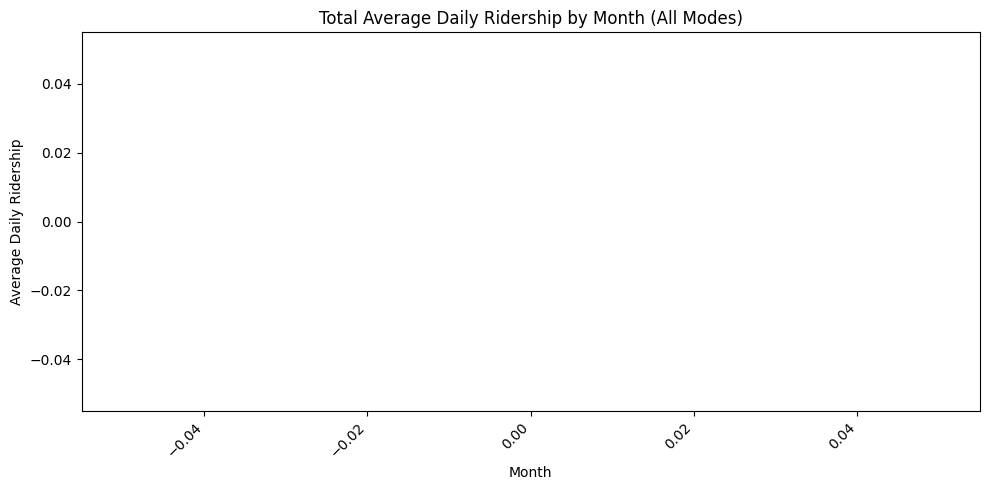

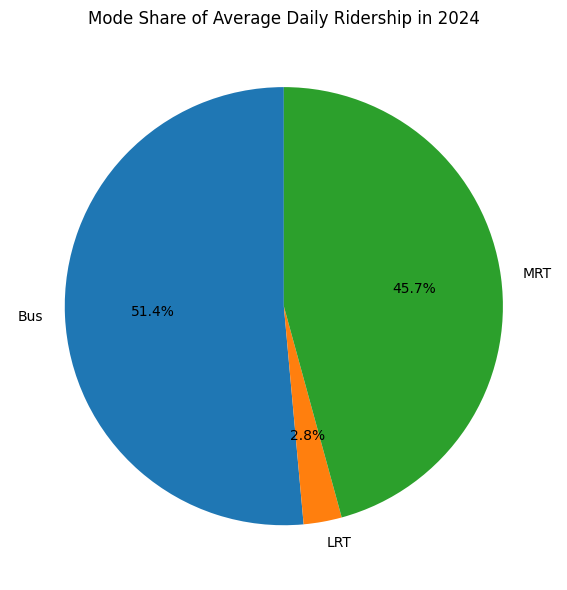

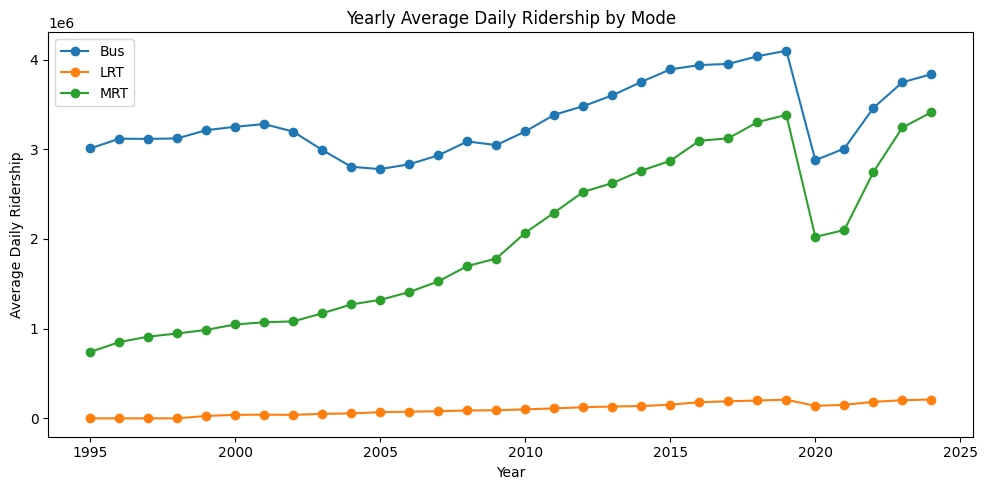

Example mode used for scatter & regression later: MRT


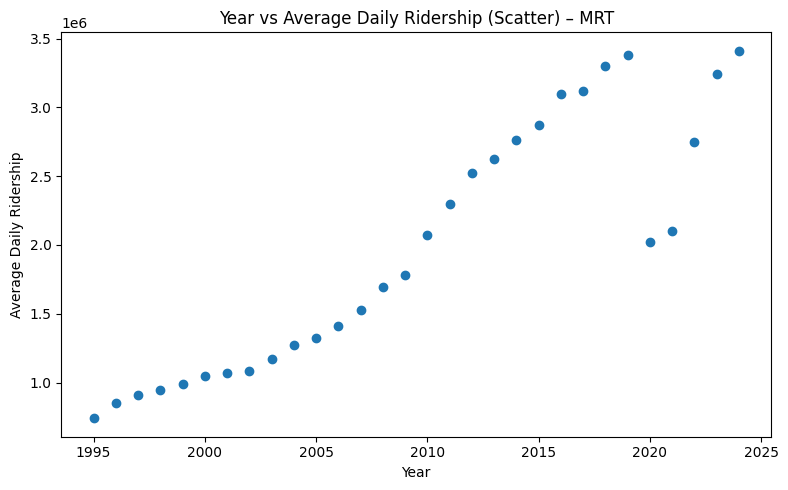

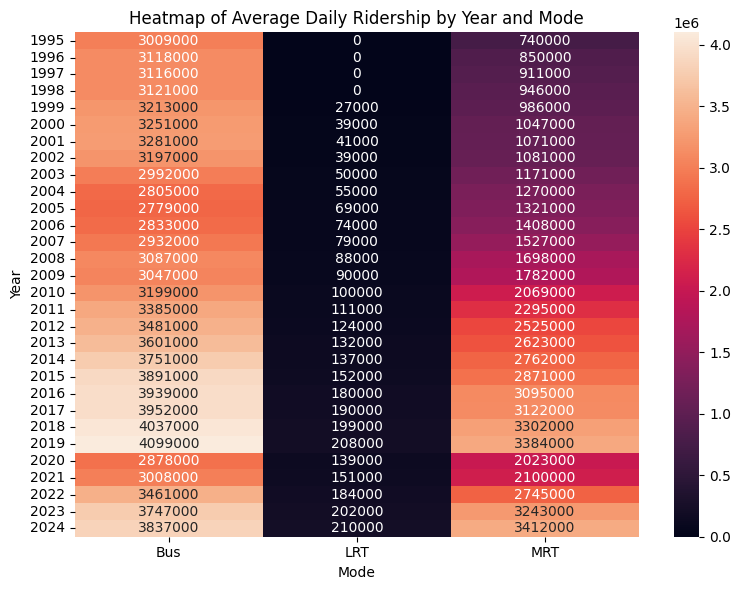

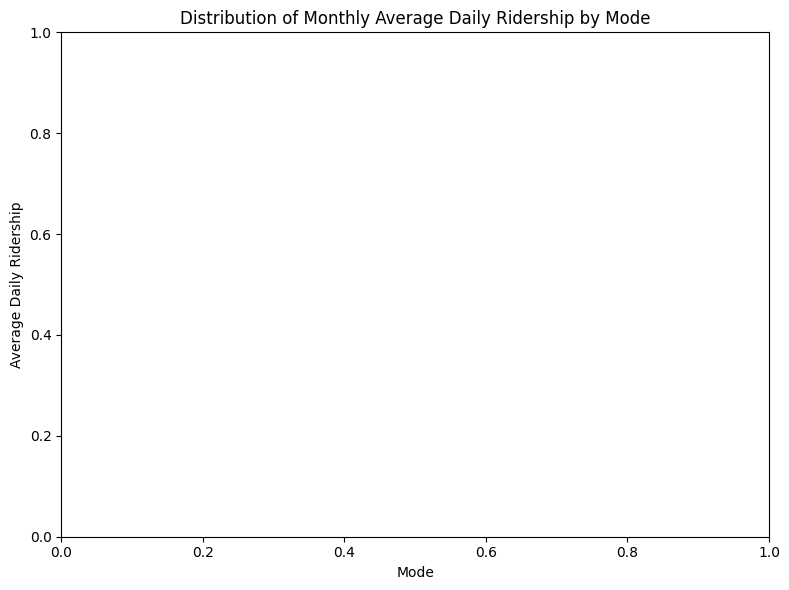

In [9]:
# ============================================
# Cell 3 – A. BASIC PLOTS
# Run this after Cell 2 so df_monthly and df_yearly exist
# ============================================

# 1. Bar chart of total monthly ridership
plot_monthly_ridership_bar(df_monthly)

# 2. Pie chart of mode share for the latest year
plot_mode_share_pie(df_yearly)

# 3. Line graph of yearly ridership by mode
plot_yearly_ridership_line(df_yearly)

# 4. Scatter plot of yearly ridership for one example mode
example_mode = df_yearly['mode'].unique()[0]
print("Example mode used for scatter & regression later:", example_mode)
plot_yearly_ridership_scatter(df_yearly, mode_filter=example_mode)

# 5. Heatmap of ridership by year & mode
plot_ridership_heatmap(df_yearly)

# 6. Boxplot of monthly ridership by mode
plot_monthly_boxplot(df_monthly)


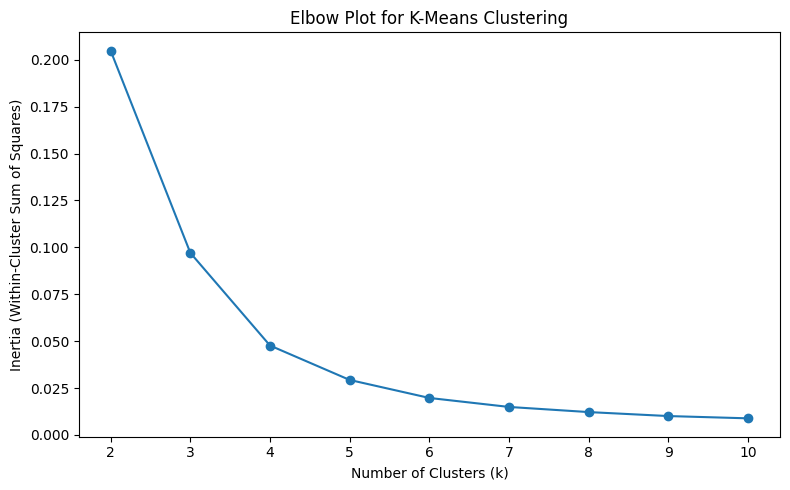

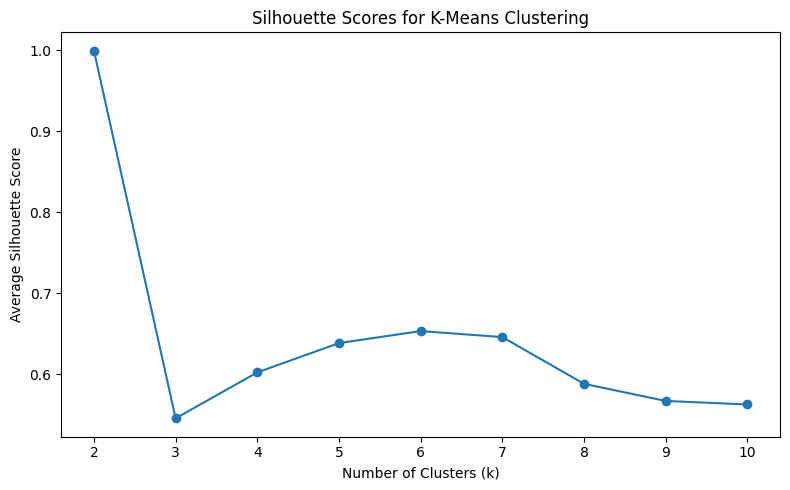

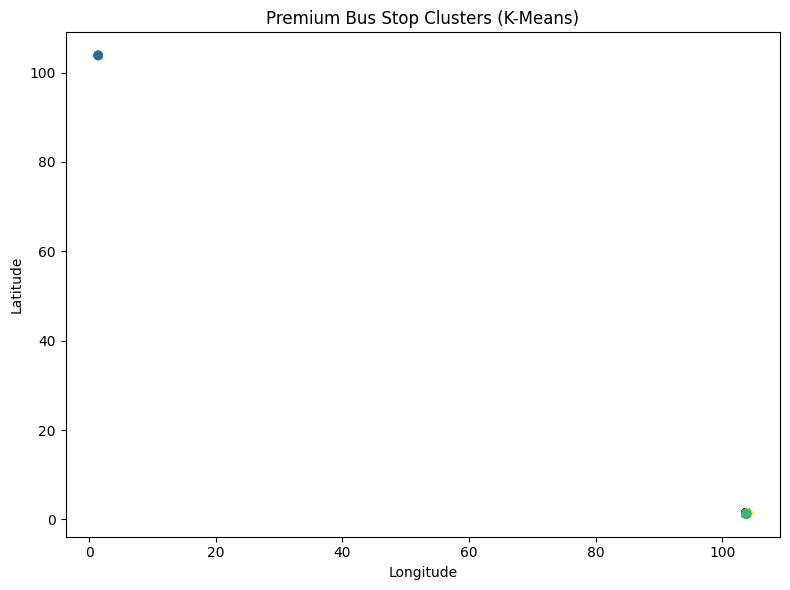

In [10]:
# ============================================
# Cell 4 – B. CLUSTERING ON PREMIUM BUS STOPS
# Run this after Cell 2 so df_premium exists
# ============================================

# Prepare features (lat/long) for clustering
X_scaled, scaler = prepare_bus_features_for_clustering(df_premium)

# 7. Elbow plot for K-means
plot_elbow_curve(X_scaled, max_k=10)

# 8. Silhouette scores vs K
plot_silhouette_scores(X_scaled, max_k=10)

# Choose a specific K (e.g. 4) for final clustering
k_chosen = 4
model_kmeans, labels = run_kmeans_clustering(X_scaled, n_clusters=k_chosen)

# Add cluster labels back to dataframe
df_premium['cluster'] = labels

# 9. Scatter plot of clustered bus stops
plot_clustered_bus_stops(df_premium, labels)


Mode used for linear regression: MRT


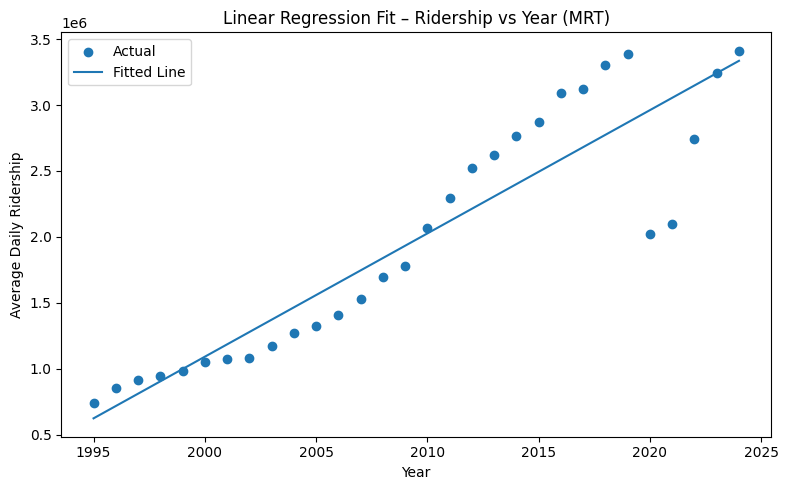

In [11]:
# ============================================
# Cell 5 – C. LINE FITTING (LINEAR REGRESSION)
# Run this after Cell 2 (and optionally Cell 3)
# ============================================

# Choose a mode for regression – here we reuse the first mode available
example_mode_for_fit = df_yearly['mode'].unique()[0]
print("Mode used for linear regression:", example_mode_for_fit)

# Perform linear regression on that mode
model_lr, X_lr, y_lr = perform_linear_regression(df_yearly, mode_filter=example_mode_for_fit)

# Plot regression fit
plot_linear_regression_fit(model_lr, X_lr, y_lr, mode_filter=example_mode_for_fit)
